In [44]:
!gdown 1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
!gdown 13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
!gdown 1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
!gdown 1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
!unzip -q data

Downloading...
From (original): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG
From (redirected): https://drive.google.com/uc?id=1UG_bXl_vgCdVq3kgf8Y-StXPCttlpFAG&confirm=t&uuid=a188fb08-ff98-4ee4-ab0f-952520ee2560
To: /content/data.zip
100% 960M/960M [00:09<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=13mdK-jX_eDNa5v-HB34WOS3WNHSru_ir
To: /content/merged.json
100% 2.58M/2.58M [00:00<00:00, 130MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h9FV9dVvcvLo97reN9_2dbg0QFKyVED2
To: /content/val.json
100% 144k/144k [00:00<00:00, 113MB/s]
Downloading...
From: https://drive.google.com/uc?id=1es9gtEtl1yiX4DVFRI_Qi0fQg0R9qUO2
To: /content/faulty.csv
100% 25.8k/25.8k [00:00<00:00, 77.6MB/s]
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [45]:
!pip -q install transformers openai-clip wandb

In [19]:
from PIL import Image
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm import trange
import clip
from transformers import CLIPProcessor, CLIPModel
from PIL import ImageFile
import random
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import pandas as pd
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [20]:
# WanB login - Make sure to change the login call to wandb.login(key='<yourapikey') the first time you run.
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [21]:
wandb.init(
      project="mlrc",
      name=f"norm_sch_lb_10eph_fixed",
      config={"learning_rate": 5e-6,"epochs": 10,})

per_step_train_loss,▁▆█▆█▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▆▁▁█▁▁▁▁▆▁▁█▁▁▁▁▆▁
running_train_loss,▆██▇█▁▃▃▃▃▄▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
per_step_train_loss,0.24682
running_train_loss,0.39567


In [22]:
##options for model
ckpt_pth = '' # path to a checkpoint file
en_scheduler = True #enable scheduler
en_balanced_lambda = True #enable lambda balancing as decscribed in Section X.X of our paper
en_data_check = False #iterate over the dataloader once to check if there are any faulty images present (for other datasets)
fix_faulty = True #Required to be true for our dataset

In [23]:
#paths for the images and their respective data
json_path = '/content/merged.json'
image_path = '/content/data/merged'
val_image_path = '/content/data/VAL'
val_json_path = '/content/val.json'
faulty_path = '/content/faulty.csv'

In [24]:
# Loading and fixing raw training data
with open(json_path, 'r') as f:
    input_data = []
    for line in f:
        obj = json.loads(line)
        input_data.append(obj)

if fix_faulty:
  faulty = pd.read_csv(faulty_path)
  indexes = list(faulty["index"])
  json_strs = list(faulty["json_str"])

  for i in trange(len(indexes)):
    input_data[int(indexes[i])] = json.loads(json_strs[i])


100%|██████████| 100/100 [00:00<00:00, 53980.75it/s]


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [26]:
# class for the dataset, handles image preprocessing and text tokenization
class image_title_dataset():
    def __init__(self, list_image_path,list_txt,list_txt_cf):
        # Initialize image paths and corresponding texts
        self.image_path = list_image_path
        # Tokenize text using CLIP's tokenizer
        self.title  = clip.tokenize(list_txt)
        self.cf_title = clip.tokenize(list_txt_cf)
        self.raw_txts = list_txt
        self.raw_counts = list_counts

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        # Preprocess image using CLIP's preprocessing function
        image = preprocess(Image.open(self.image_path[idx]))
        title = self.title[idx]
        cf_title = self.cf_title[idx]
        raw_txts = self.raw_txts[idx]
        raw_counts = self.raw_counts[idx]
        return image, title, cf_title, raw_txts, raw_counts

In [27]:
num2word = {1 : 'one', 2 : 'two', 3 : 'three', 4 : 'four', 5 : 'five',
               6 : 'six', 7 : 'seven', 8 : 'eight', 9 : 'nine', 10 : 'ten'}

In [28]:
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

def count_loss(ei,ek,ek_cf):

    # Normalize embeddings
    ei = torch.squeeze(ei).to(torch.float64)/ei.norm(dim=1)
    ek = torch.squeeze(ek).to(torch.float64)/ek.norm(dim=1)
    ek_cf = torch.squeeze(ek_cf).to(torch.float64)/ek_cf.norm(dim=1)

    # Calculate loss
    loss = -torch.log(torch.exp(torch.dot(ei,ek))/(torch.exp(torch.dot(ei,ek))+torch.exp(torch.dot(ei,ek_cf))))

    return loss

In [29]:
def generate_caps(cap,count,counterfactual=False):
  '''
  generate_caps() - Function to generate captions by replacing the number in the current caption. Only for counting images.

  inputs:
    - cap:str = The caption of the image
    - count:int = The count of the image
    - counterfactual:bool = If true a random number is chosen for replacing the current number otherwise produces all possible valid combinations.

  outputs:
    - val_caps:str or list() of str = List containing all combinations of the caption, or str containing caption with count replaced with a random number,
      depending on value of counterfactual.
  '''

  val_caps = []
  if counterfactual==False:
    for c in list(set(range(1,11)) - set([1])):
      val_cap = cap.replace(num2word[count],num2word[c])
      val_caps.append(val_cap)

  if counterfactual==True:
    l = list(set(range(1,11)) - set([1,count]))
    n = random.choice(l)
    val_caps = cap.replace(num2word[count],num2word[n])

  return val_caps

In [30]:
## Variables for logging
list_image_path = []
list_txt = []
list_txt_cf = []
list_counts = []


## Initalising the Dataloader for the training data
for item in input_data:
  img_path = image_path +str('/')+ item['pths'].split('/')[-1]
  caption = item['caps'][:110]
  # caption = item['caps']
  counts = item['counts']


  if counts>0:
    cf_cap = generate_caps(caption.lower(),counts,counterfactual=True)
    list_txt_cf.extend([cf_cap] * 5)

  list_image_path.append(img_path)
  list_txt.append(caption)
  list_counts.append(counts)

dataset = image_title_dataset(list_image_path, list_txt, list_txt_cf)
train_dataloader = DataLoader(dataset, batch_size=5, shuffle=False) #Define your own dataloader

# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

if device == "cpu":
  model.double()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=5e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset

if en_scheduler:
  linear = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1/3, total_iters=5)
  cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,last_epoch=10)
  scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[linear,cosine], milestones=[5])

if en_data_check: #checking data
  pbar = tqdm(train_dataloader, total=len(train_dataloader))
  for batch in pbar:
    pass

# Loading from checkpoint (if enabled)
if len(ckpt_pth)>0:
  api = wandb.Api()
  run = api.run(ckpt_pth)

  run.file("model_9.pt").download()
  model_ckpt = torch.load('model_9.pt')
  model.load_state_dict(model_ckpt)

  run.file("optimzier_9.pt").download()
  optimizer_ckpt = torch.load('optimizer_9.pt')
  optimizer.load_state_dict(optimizer_ckpt)

  run.file("scheduler_9.pt").download()
  scheduler_ckpt = torch.load('scheduler_9.pt')
  scheduler.load_state_dict(scheduler_ckpt)

print("\nData and model ready.")




Data and model ready.


In [31]:
def get_lambda(text,count):
  '''
  get_lambda() - Function implementing Lambda Balancing as described in Section X.X of our paper.
  Applies when en_lambda is set to True. Recommended to use for small, class-imbalanced training data.

  inputs:
    - text:str = caption of the (counting) image

  outputs:
    - lmbda:float = lambda corresponding to the given caption
  '''

  lmbda = 1
  l = list_counts
  n_count = len(train_dataloader)



  if num2word[count] in text and count == 2: lmbda = 1-(list_counts.count(2)/n_count)
  if num2word[count] in text and count == 3: lmbda = 1-(list_counts.count(3)/n_count)
  if num2word[count] in text and count == 4: lmbda = 1-(list_counts.count(4)/n_count)
  if num2word[count] in text and count == 5: lmbda = 1-(list_counts.count(5)/n_count)
  if num2word[count] in text and count == 6: lmbda = 1-(list_counts.count(6)/n_count)
  if num2word[count] in text and count == 7: lmbda = 1-(list_counts.count(7)/n_count)
  if num2word[count] in text and count == 8: lmbda = 1-(list_counts.count(8)/n_count)
  if num2word[count] in text and count == 9: lmbda = 1-(list_counts.count(9)/n_count)
  if num2word[count] in text and count == 10: lmbda = 1-(list_counts.count(10)/n_count)

  return lmbda

#get_lambda("ten dogs")

In [32]:
def get_preds(pth,model):
  '''
    get_preds() - Runs the validation loop, obtains predictions for the zero-shot classification task and reports validation metrics.

    inputs:
        - pth: Path to validation data
        - model:CLIPModel

    outputs:
        - y:[int] = Ground Truth
        - y_pred:[int] = Model Predictions
        - np.mean(all_val_loss):float = mean validation loss on the validation set
        - val_acc: Zero-Shot Classifiaction Accuracy
        - f1_scores: F1 Scores for each class
  '''
  #opening validation data
  with open(pth, 'r') as f:
      val_input_data = []
      for line in f:
          obj = json.loads(line)
          val_input_data.append(obj)

  all_sims = []
  c = 0
  all_val_loss = []
  y = []
  y_pred = []
  lbls = []
  lmbda = 1

  with torch.no_grad():
    for i in trange(len(val_input_data)):
      try:

        sims = []
        img = Image.open(val_input_data[i]['pths'])
        cap = val_input_data[i]['caps'].lower()
        cap = cap[0:77]
        count = val_input_data[i]['counts']

        # print(count)
        cf_cap = generate_caps(cap,count,counterfactual=True)
        val_caps = generate_caps(cap,count)

        img = preprocess(img).to(device)
        encoded_image = model.encode_image(torch.unsqueeze(img, 0))
        encoded_image = encoded_image.to(device)

        tokenized_f_text = clip.tokenize(cap).to(device)
        encoded_f_text = model.encode_text(tokenized_f_text)
        encoded_f_text = encoded_f_text.to(device)

        tokenized_cf_text = clip.tokenize(cf_cap).to(device)
        encoded_cf_text = model.encode_text(tokenized_cf_text)
        encoded_cf_text = encoded_cf_text.to(device)

        ei = encoded_image
        ek = encoded_f_text
        ek_cf = encoded_cf_text

        for j in range(9):
          tokenized_text = clip.tokenize(val_caps[j]).to(device)
          encoded_text = model.encode_text(tokenized_text)
          encoded_text = encoded_text.to(device)

          similarity = torch.cosine_similarity(encoded_text, encoded_image)
          sims.append(float(similarity))

        all_sims.append((sims,count))
        logits_per_image, logits_per_text = model(torch.unsqueeze(img,0), tokenized_f_text)

        ground_truth = torch.arange(len(torch.unsqueeze(img,0)),dtype=torch.long,device=device)

        if en_balanced_lambda:
          lmbda = get_lambda(cap,count)


        counting_loss = count_loss(ei,ek,ek_cf)
        val_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        all_val_loss.append(val_loss.item())

        # print(val_loss.item())
      except:
         c=c+1
         pass
    print(c)
  # return np.mean(all_val_loss),all_sims
  for i in range(len(all_sims)):
    y_pred.append(all_sims[i][0].index(max(all_sims[i][0]))+2)
    y.append(all_sims[i][1])

  val_acc = accuracy_score(y, y_pred)
  f1_scores = f1_score(y, y_pred, average=None)

  return y,y_pred,np.mean(all_val_loss),val_acc,f1_scores



In [33]:
def store_cf(y,y_pred,epoch):
  '''
  store_cf() - Function saving unnormalised confusion matrix to wandb (if enabled) or locally

  inputs:
    - y:[int] = ground truth
    - y_pred:[int] = model predictions
    - epoch:int = current epoch

  outputs:
    - unnormalised confusion matrix as a pdf
  '''
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)

  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_{}.pdf"))
  except:
    plt.savefig("/content/cfmat.pdf")
    files.download("/content/cfmat.pdf")

  plt.show()



In [34]:
def store_cf_norm(y,y_pred,epoch):
  '''
  store_cf_norm() - Function saving normalised confusion matrix to wandb (if enabled) or locally

  inputs:
    - y:[int] = ground truth
    - y_pred:[int] = model predictions
    - epoch:int = current epoch

  outputs:
    - normalised confusion matrix as a pdf
  '''
  lbls = []
  for i in range(len(np.unique(y))):
    lbls.append(num2word[np.unique(y)[i]])

  labels = lbls
  cf_matrix = confusion_matrix(y, y_pred,normalize='true')
  cm_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = labels)
  cm_display.plot()

  try:
    plt.savefig(os.path.join(wandb.run.dir, f"cfmat_norm_{epoch}.pdf"))
    # files.download(os.path.join(wandb.run.dir, f"cfmat_norm_{}.pdf"))
  except:
    plt.savefig("/content/cfmat_norm.pdf")
    files.download("/content/cfmat_norm.pdf")

  plt.show()



Epoch 0/10, Loss: 0.4137:   3%|▎         | 58/2101 [00:15<10:01,  3.39it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:14<00:00,  7.29it/s]


31


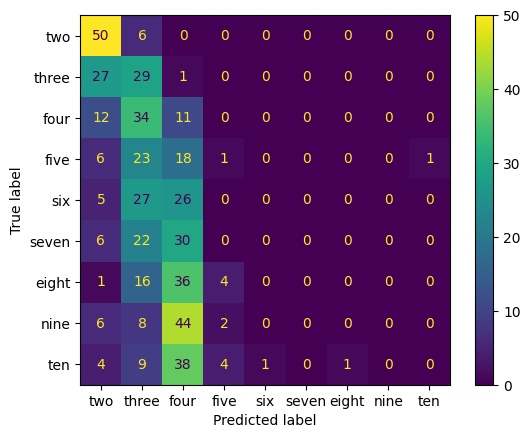

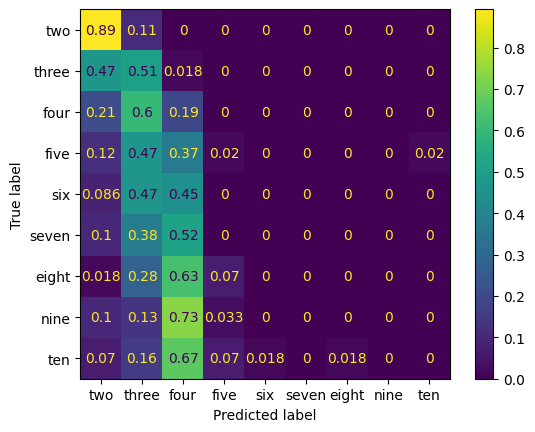

Validation Loss: 0.6159385408700297
Validation Accuracy: 0.1787819253438114


Epoch 1/10, Loss: 0.3858:   3%|▎         | 58/2101 [00:15<08:44,  3.90it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.32it/s]


31


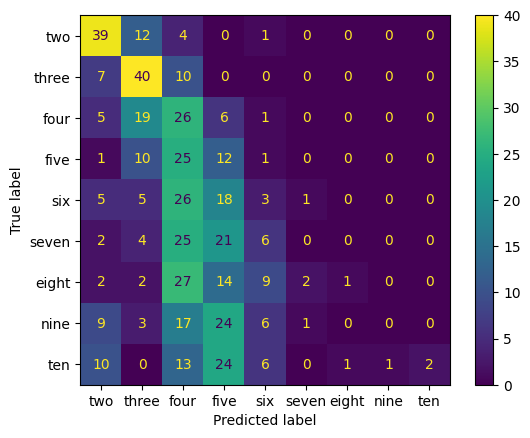

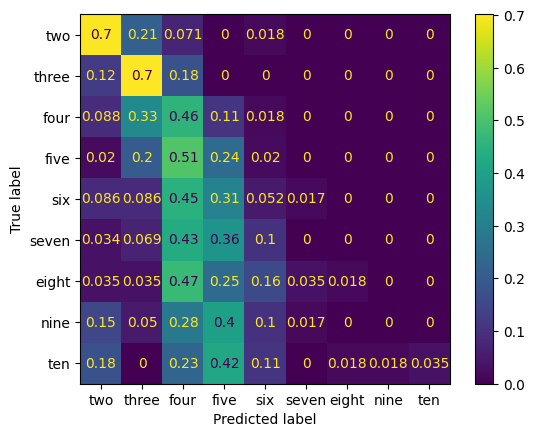

Validation Loss: 0.5969626458805672
Validation Accuracy: 0.24165029469548133


Epoch 2/10, Loss: 0.4022:   3%|▎         | 58/2101 [00:15<08:31,  3.99it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.30it/s]


31


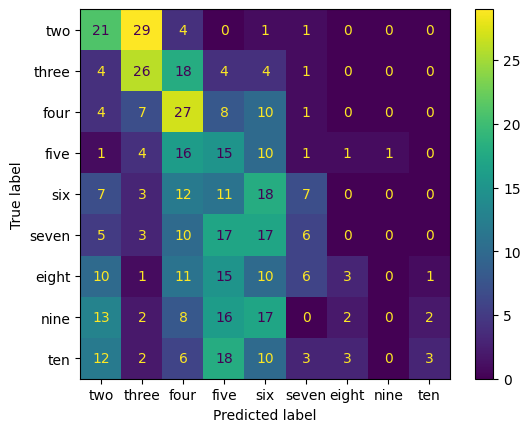

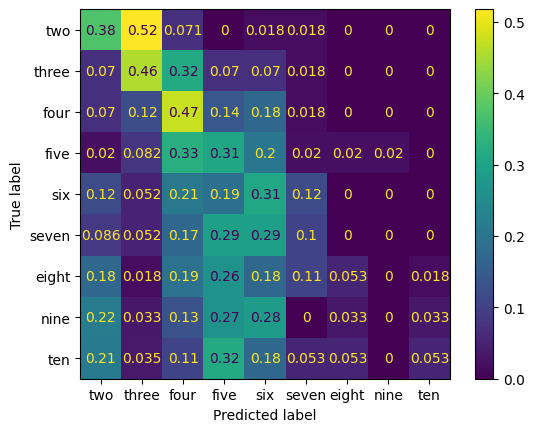

Validation Loss: 0.6039172242634603
Validation Accuracy: 0.2337917485265226


Epoch 3/10, Loss: 0.4605:   3%|▎         | 58/2101 [00:15<09:06,  3.74it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:13<00:00,  7.34it/s]


31


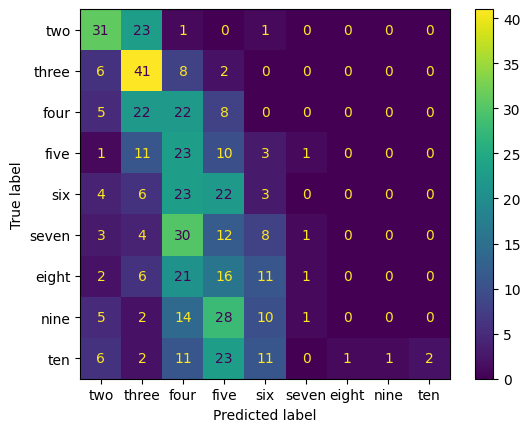

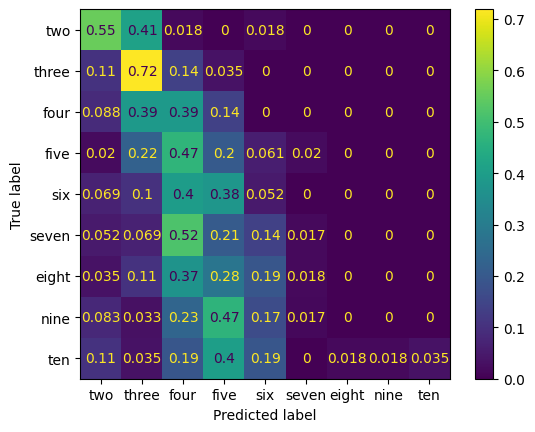

Validation Loss: 0.6049148049170888
Validation Accuracy: 0.21611001964636542


Epoch 4/10, Loss: 0.4710:   3%|▎         | 58/2101 [00:15<08:52,  3.83it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:14<00:00,  7.22it/s]


31


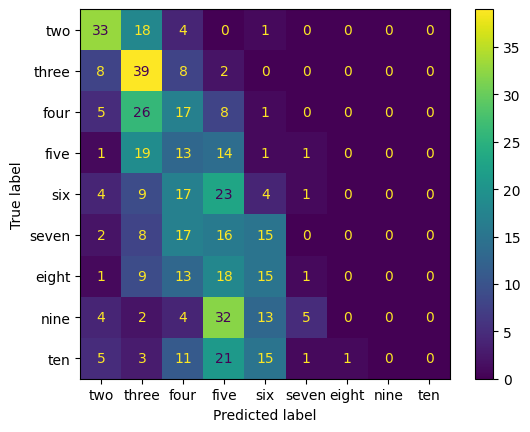

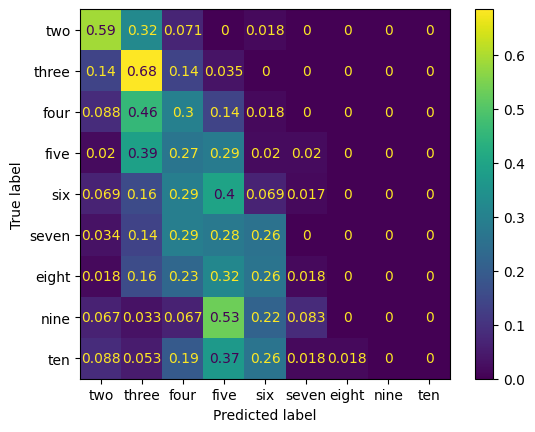

Validation Loss: 0.6010436951938083
Validation Accuracy: 0.21021611001964635


Epoch 5/10, Loss: 0.4332:   3%|▎         | 58/2101 [00:15<08:44,  3.90it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:14<00:00,  7.28it/s]


31


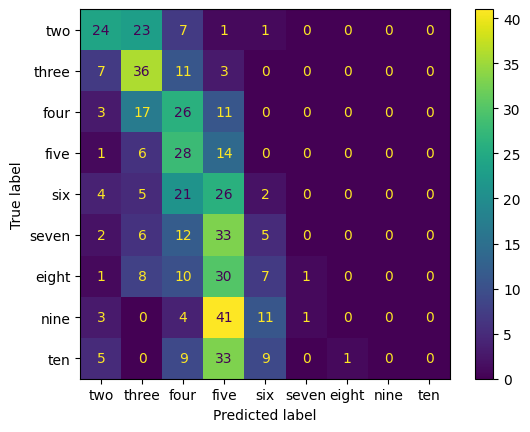

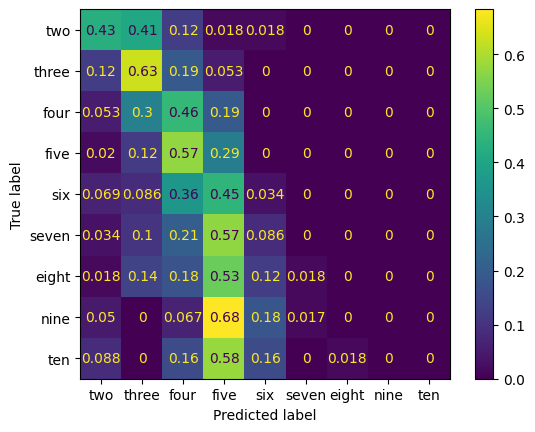

Validation Loss: 0.5975030980668812
Validation Accuracy: 0.20039292730844793


Epoch 6/10, Loss: 0.4067:   3%|▎         | 58/2101 [00:15<08:50,  3.85it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:15<00:00,  7.11it/s]


31


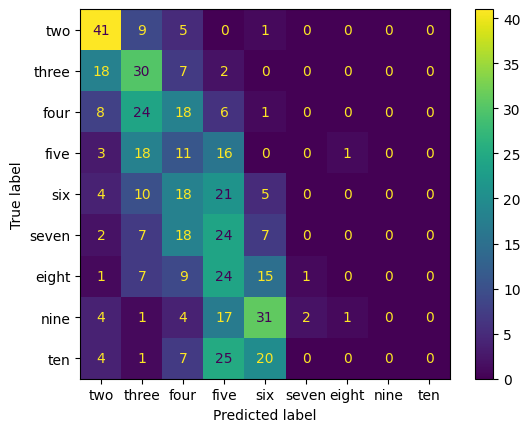

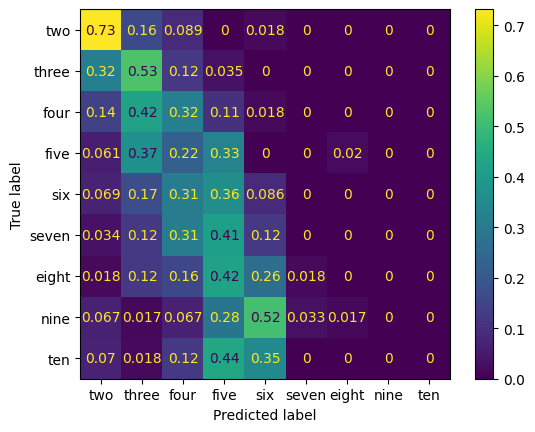

Validation Loss: 0.5973834049854992
Validation Accuracy: 0.21611001964636542


Epoch 7/10, Loss: 0.3757:   3%|▎         | 58/2101 [00:15<09:04,  3.75it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:18<00:00,  6.84it/s]


31


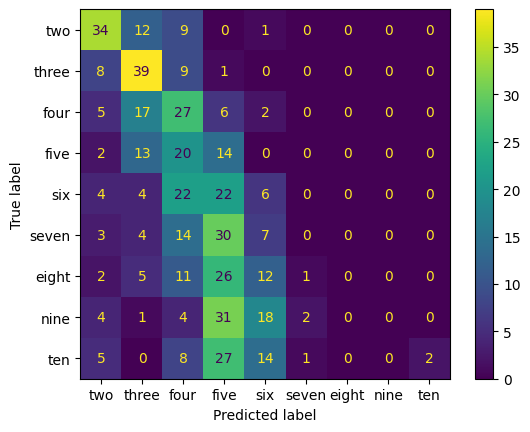

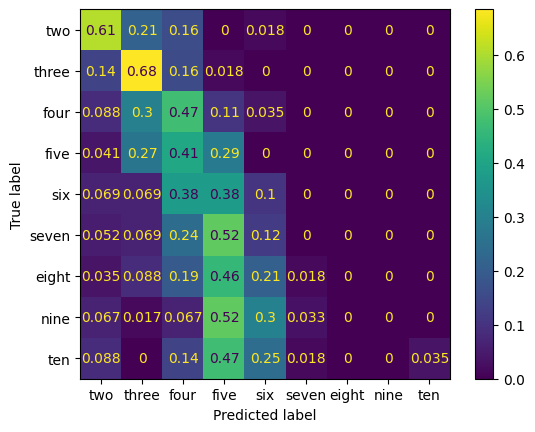

Validation Loss: 0.5929051531938684
Validation Accuracy: 0.23968565815324164


Epoch 8/10, Loss: 0.4088:   3%|▎         | 58/2101 [00:15<08:58,  3.79it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:15<00:00,  7.18it/s]


31


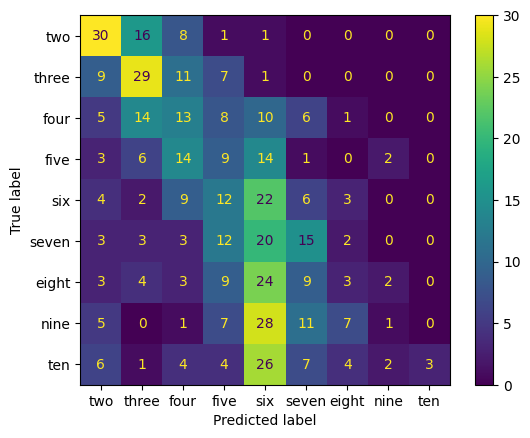

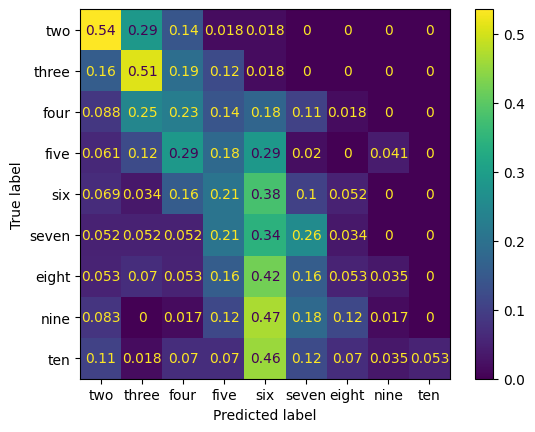

Validation Loss: 0.5877011883357239
Validation Accuracy: 0.2455795677799607


Epoch 9/10, Loss: 0.3895:   3%|▎         | 58/2101 [00:16<11:48,  2.88it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 540/540 [01:17<00:00,  6.98it/s]


31


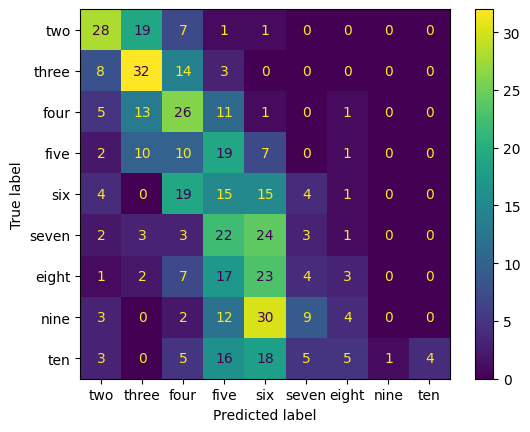

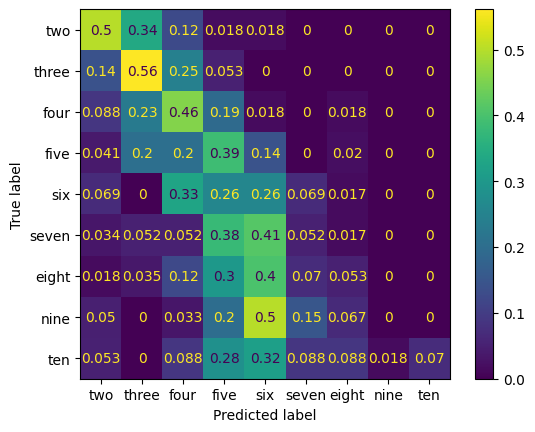

Validation Loss: 0.5818665670638736
Validation Accuracy: 0.2554027504911591


In [35]:
# Train the model
train_arr = []
val_arr = []
num_epochs = 10
lmbda = 1

for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))

    train_loss_arr = []
    val_loss_arr = []

    for batch in pbar:

        optimizer.zero_grad()
        images,texts,cf_texts,raw_txts,raw_counts = batch

        images = images.to(device)
        texts = texts.to(device)
        cf_texts = cf_texts.to(device)

        encoded_imgs = model.encode_image(images)
        encoded_texts = model.encode_text(texts)
        encoded_cf_texts = model.encode_text(torch.unsqueeze(cf_texts[4], 0))

        nc_enc_imgs = encoded_imgs[0:4]
        nc_enc_texts = encoded_texts[0:4]

        c_enc_imgs = encoded_imgs[4:]
        c_enc_texts = encoded_texts[4:]

        ei = c_enc_imgs
        ek = c_enc_texts
        ek_cf = encoded_cf_texts

        counting_loss = count_loss(ei,ek,ek_cf)
        # print(raw_txts[4])
        if en_balanced_lambda:
          lmbda = get_lambda(raw_txts[4].lower(),raw_counts[4].item())

        # print(lmbda)
        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = ((loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2) + (lmbda * counting_loss)
        train_loss_arr.append(total_loss.item())
        # Backward pass

        total_loss.backward()
        if device == "cpu":
            optimizer.step()
            if en_scheduler:
              scheduler.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            if en_scheduler:
              scheduler.step()
            clip.model.convert_weights(model)

        wandb.log({"per_step_train_loss": total_loss.item()})
        wandb.log({"running_train_loss": sum(train_loss_arr)/len(train_loss_arr)})


        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {sum(train_loss_arr)/len(train_loss_arr):.4f}")

    y,y_pred,val_loss,val_acc,f1_scores = get_preds(val_json_path,model)
    val_loss_arr.append(val_loss)
    store_cf(y,y_pred,epoch)
    store_cf_norm(y,y_pred,epoch)

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")
    wandb.log({"per_epoch_val_loss": val_loss})
    wandb.log({"per_epoch_val_acc": val_acc})

    for i in range(len(f1_scores)):
      wandb.log({f"f1_score_class{i}": f1_scores[i]})

    if (epoch+1) % 10 == 0:
      torch.save(model.state_dict(), os.path.join(wandb.run.dir, f"model_{epoch}.pt"))
      torch.save(optimizer.state_dict(), os.path.join(wandb.run.dir, f"optimizer_{epoch}.pt"))
      if en_scheduler:
        torch.save(scheduler.state_dict(), os.path.join(wandb.run.dir, f"scheduler_{epoch}.pt"))


    wandb.log({"per_epoch_loss": np.mean(train_loss_arr)})
    train_arr.append(train_loss_arr)


In [36]:
wandb.finish()

f1_score_class0,██▁▆▇▅█▇▅▆
f1_score_class1,▁█▄▇▅▆▄█▆▇
f1_score_class2,▁▅▇▄▄▆▅▇▄█
f1_score_class3,▁▅▇▄▅▄▆▅▅█
f1_score_class4,▁▃█▃▃▂▃▄█▆
f1_score_class5,▁▁▅▂▁▁▁▁█▃
f1_score_class6,▁▄█▁▁▁▁▁▇▇
f1_score_class7,▁▁▁▁▁▁▁▁█▁
f1_score_class8,▁▅▆▅▁▁▁▅▆█
per_epoch_loss,▂▁▃██▅▅▃▂▂
per_epoch_val_acc,▁▇▆▄▄▃▄▇▇█


In [37]:
from google.colab import runtime
runtime.unassign()